# MATRIXS REQUIRED TO DISPLAY

1. Each and every model with hyperparameter tuning (learning rate).

2. Validation loss curve, Training loss curve, Validation accuracy curve

3. Model training performance matrices (precision, recall, and F1 score)

4. Model testing performance matrices (precision, recall, and F1 score)

5. Number of epochs model trained on.

6. Dataset Before and After Augmentation.

7. Testing Confusion matrix.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from PIL import Image
import os
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import zipfile

import torch.nn.functional as F
from rich.console import Console
from rich.progress import Progress, BarColumn, TimeElapsedColumn, TimeRemainingColumn
from rich.table import Table

import pandas as pd
from torch.cuda.amp import autocast, GradScaler


from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix
import seaborn as sns
import numpy as np

In [2]:
# Install Git in case it's not available in your environment
!apt-get install git

# Clone the repository from GitHub
!git clone https://github.com/Samin1362/MerakiNexus-V2.git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.15).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Cloning into 'MerakiNexus-V2'...
remote: Enumerating objects: 6535, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 6535 (delta 20), reused 34 (delta 13), pack-reused 6479 (from 2)
Receiving objects: 100% (6535/6535), 1.93 GiB | 44.03 MiB/s, done.
Resolving deltas: 100% (159/159), done.
Updating files: 100% (6238/6238), done.


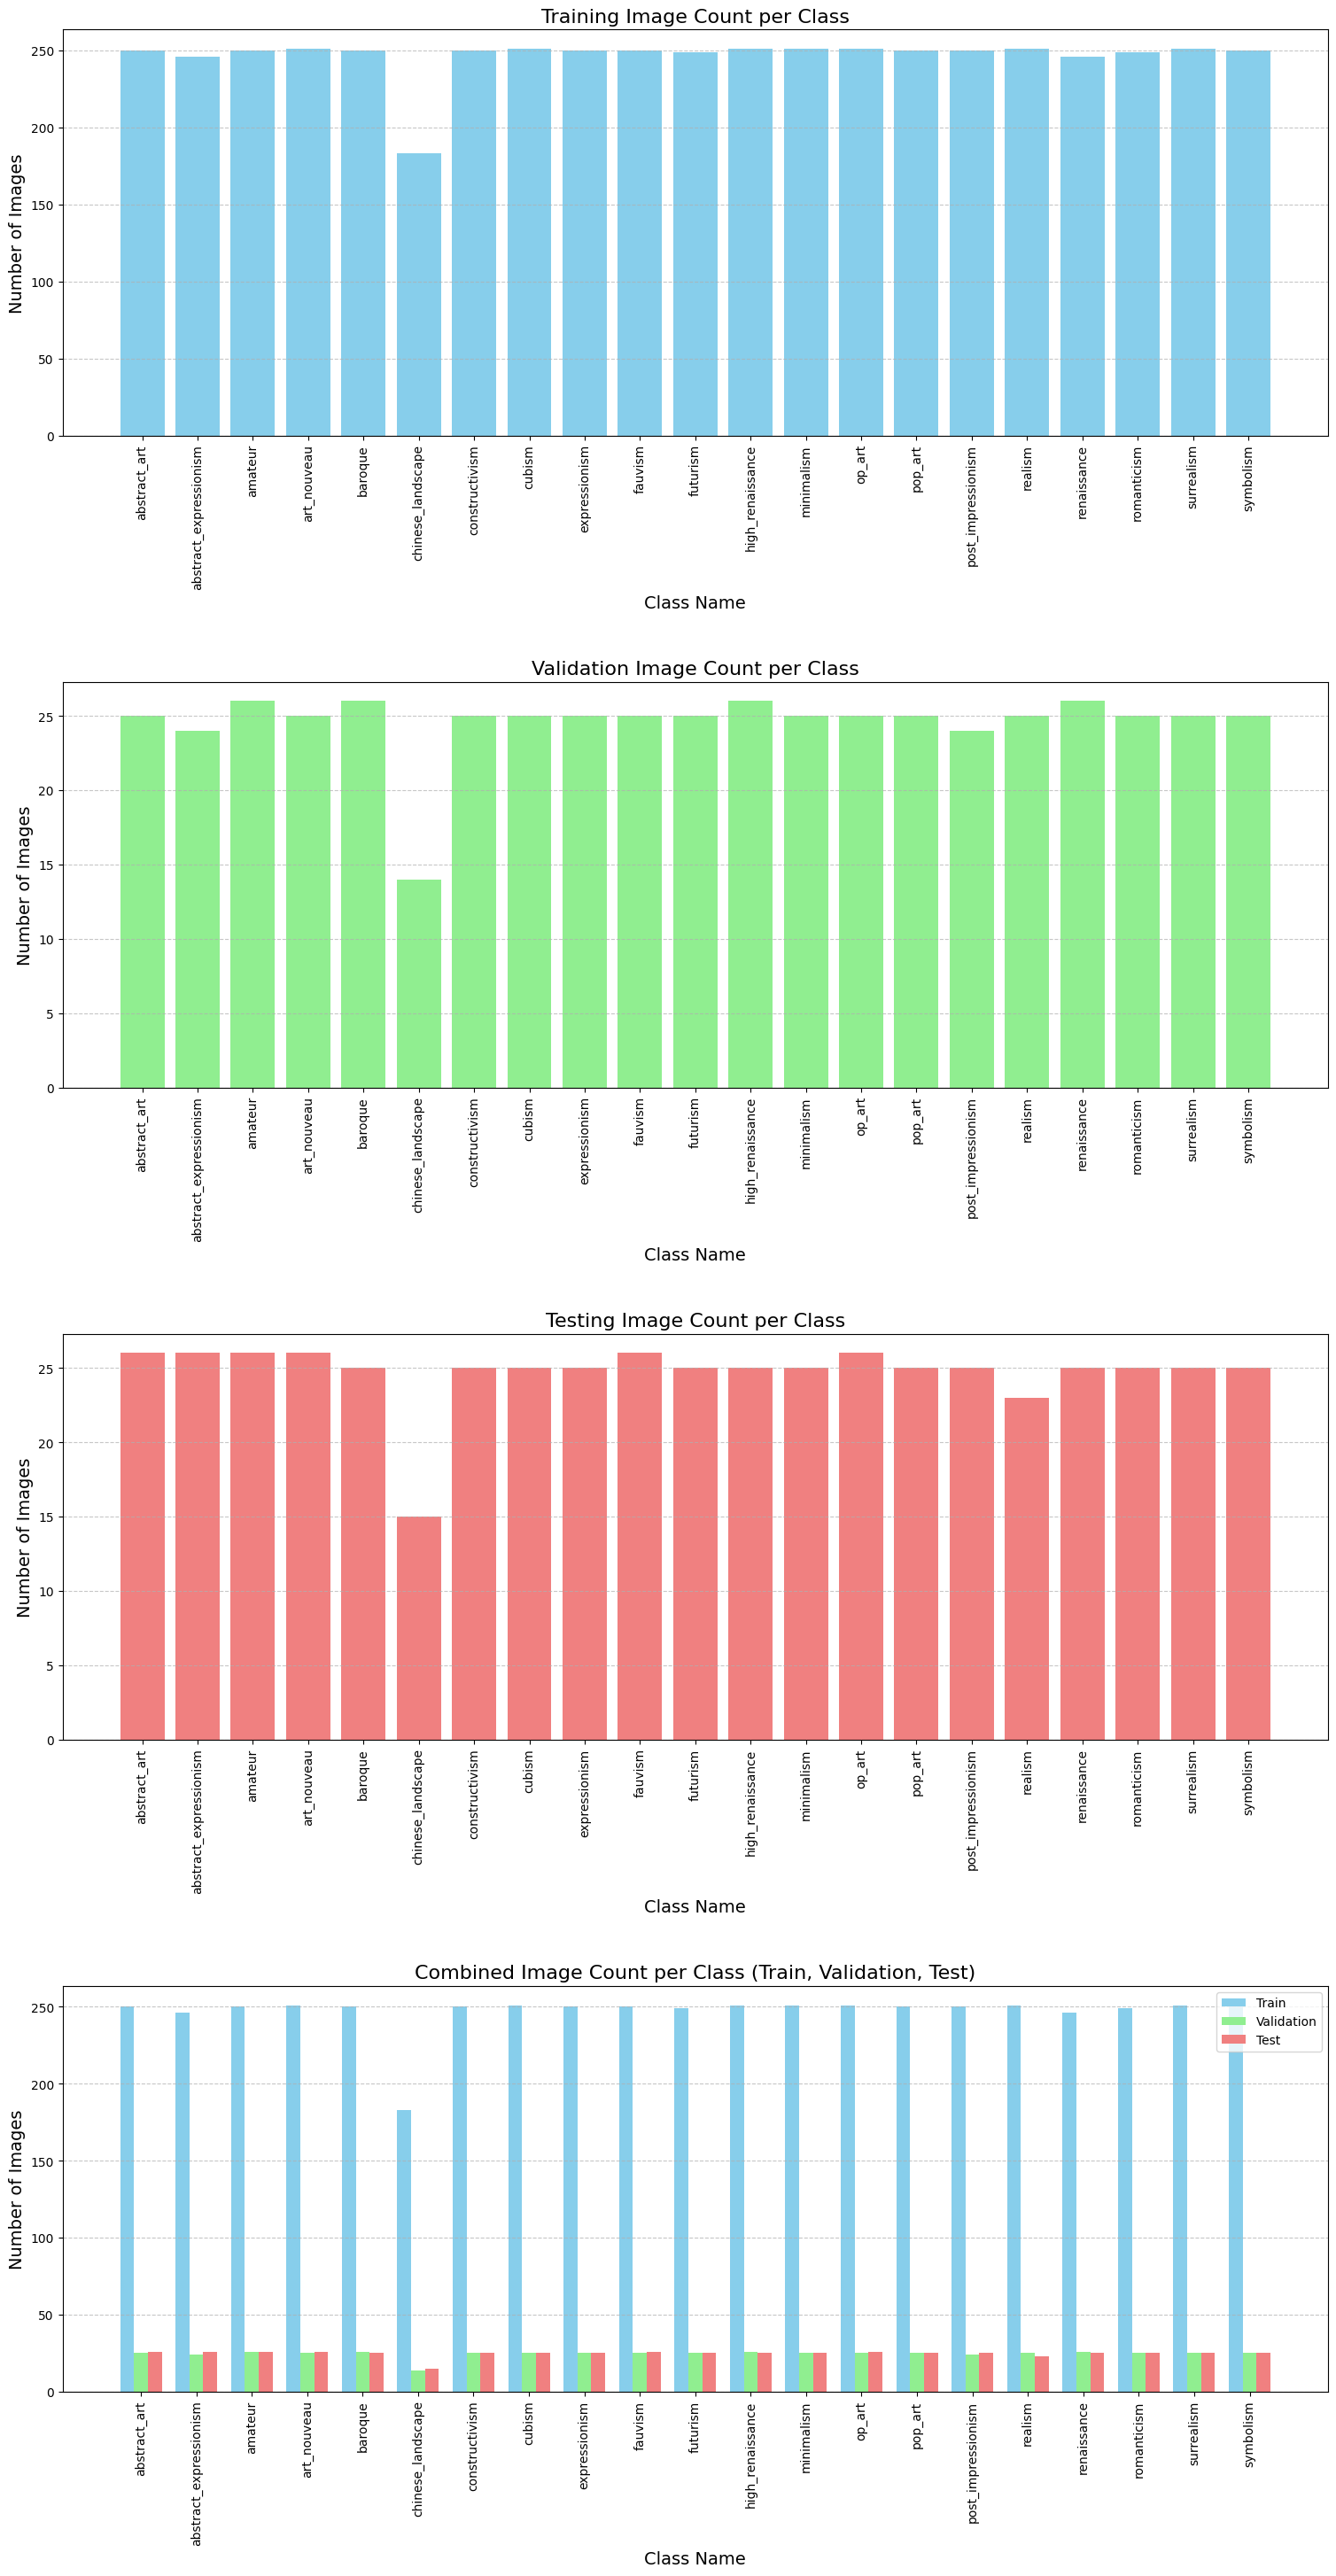

In [3]:
import os
import matplotlib.pyplot as plt
from torchvision import datasets

# Define dataset path
dataset_path = "/content/MerakiNexus-V2/art_classification_model/dataset"  # Update path if needed

# Load datasets
train_dataset = datasets.ImageFolder(root=f"{dataset_path}/train")
val_dataset = datasets.ImageFolder(root=f"{dataset_path}/val")
test_dataset = datasets.ImageFolder(root=f"{dataset_path}/test")

# Get class names and initialize counters
class_names = train_dataset.classes
train_image_counts, val_image_counts, test_image_counts = [], [], []

# Count images per class
for class_name in class_names:
    train_count = len(os.listdir(os.path.join(train_dataset.root, class_name)))
    val_count = len(os.listdir(os.path.join(val_dataset.root, class_name)))
    test_count = len(os.listdir(os.path.join(test_dataset.root, class_name)))

    train_image_counts.append(train_count)
    val_image_counts.append(val_count)
    test_image_counts.append(test_count)

# Create vertically stacked subplots
fig, axes = plt.subplots(4, 1, figsize=(16, 30))  # Wider + taller for readability

# Common x-axis style
def style_x_axis(ax):
    ax.set_xticks(range(len(class_names)))
    ax.set_xticklabels(class_names, rotation=90, fontsize=10)
    ax.set_xlabel("Class Name", fontsize=14)
    ax.set_ylabel("Number of Images", fontsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Training set plot
axes[0].bar(range(len(class_names)), train_image_counts, color='skyblue')
axes[0].set_title('Training Image Count per Class', fontsize=16)
style_x_axis(axes[0])

# Validation set plot
axes[1].bar(range(len(class_names)), val_image_counts, color='lightgreen')
axes[1].set_title('Validation Image Count per Class', fontsize=16)
style_x_axis(axes[1])

# Test set plot
axes[2].bar(range(len(class_names)), test_image_counts, color='lightcoral')
axes[2].set_title('Testing Image Count per Class', fontsize=16)
style_x_axis(axes[2])

# Combined view with grouped bars
bar_width = 0.25
x = list(range(len(class_names)))

axes[3].bar([i - bar_width for i in x], train_image_counts, width=bar_width, label='Train', color='skyblue')
axes[3].bar(x, val_image_counts, width=bar_width, label='Validation', color='lightgreen')
axes[3].bar([i + bar_width for i in x], test_image_counts, width=bar_width, label='Test', color='lightcoral')

axes[3].set_title('Combined Image Count per Class (Train, Validation, Test)', fontsize=16)
axes[3].set_xticks(x)
axes[3].set_xticklabels(class_names, rotation=90, fontsize=10)
axes[3].set_xlabel("Class Name", fontsize=14)
axes[3].set_ylabel("Number of Images", fontsize=14)
axes[3].legend()
axes[3].grid(axis='y', linestyle='--', alpha=0.7)

# Final layout adjustments
plt.tight_layout(pad=4)
plt.show()


| **Hyperparameter**        | **Value**                                                   | **Description**                                                  |
| ------------------------- | ----------------------------------------------------------- | ---------------------------------------------------------------- |
| `model_name`              | `"pit_b_224"`                                               | Pretrained Position Induced Transformer from `timm`              |
| `pretrained`              | `True`                                                      | Use pretrained weights                                           |
| `input_size`              | `224 x 224`                                                 | Resized image dimensions                                         |
| `batch_size`              | `32`                                                        | Number of images per batch during training/validation            |
| `num_epochs`              | `25`                                                        | Total number of training epochs                                  |
| `learning_rate`           | `1e-4`                                                      | Learning rate for Adam optimizer                                 |
| `weight_decay`            | `1e-5`                                                      | L2 regularization coefficient                                    |
| `optimizer`               | `Adam`                                                      | Optimizer used for training                                      |
| `loss_function`           | `CrossEntropyLoss`                                          | Loss function for multi-class classification                     |
| `dropout_1`               | `0.5`                                                       | Dropout before first linear layer in classifier head             |
| `hidden_dim` (head)       | `512`                                                       | Dimension of hidden layer in classifier head                     |
| `activation`              | `ReLU`                                                      | Activation function used in classifier head                      |
| `dropout_2`               | `0.3`                                                       | Dropout before final classifier layer                            |
| `normalization`           | `BatchNorm1d(512)`                                          | Batch normalization applied after first linear layer in the head |
| `transform - Resize`      | `(224, 224)`                                                | Resize all images to 224×224                                     |
| `transform - Flip`        | `RandomHorizontalFlip()`                                    | Randomly flip images horizontally during training                |
| `transform - Rotation`    | `RandomRotation(10)`                                        | Randomly rotate images by ±10 degrees                            |
| `transform - ColorJitter` | `brightness=0.2, contrast=0.2, saturation=0.2`              | Random color variation during augmentation                       |
| `transform - Normalize`   | `mean=[0.485, 0.456, 0.406]`<br>`std=[0.229, 0.224, 0.225]` | Normalize according to ImageNet stats                            |


Train samples: 5168 | Val samples: 512 | Test samples: 511


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/295M [00:00<?, ?B/s]


Starting Training...



Epoch 1/25 Training: 100%|██████████| 162/162 [01:30<00:00,  1.80it/s, loss=2.12]


Epoch 1 | Train Loss: 2.6914 | Val Loss: 2.1779 | Val Acc: 38.48% | Time: 98.18s


Epoch 2/25 Training: 100%|██████████| 162/162 [01:27<00:00,  1.86it/s, loss=1.94]


Epoch 2 | Train Loss: 1.9903 | Val Loss: 1.8680 | Val Acc: 45.51% | Time: 95.72s


Epoch 3/25 Training: 100%|██████████| 162/162 [01:28<00:00,  1.83it/s, loss=1.78]


Epoch 3 | Train Loss: 1.7253 | Val Loss: 1.7377 | Val Acc: 47.66% | Time: 96.97s


Epoch 4/25 Training: 100%|██████████| 162/162 [01:29<00:00,  1.82it/s, loss=1.57]


Epoch 4 | Train Loss: 1.5349 | Val Loss: 1.6296 | Val Acc: 51.37% | Time: 97.54s


Epoch 5/25 Training: 100%|██████████| 162/162 [01:28<00:00,  1.82it/s, loss=1.26]


Epoch 5 | Train Loss: 1.4471 | Val Loss: 1.5376 | Val Acc: 51.95% | Time: 97.36s


Epoch 6/25 Training: 100%|██████████| 162/162 [01:29<00:00,  1.81it/s, loss=1.15]


Epoch 6 | Train Loss: 1.3457 | Val Loss: 1.5662 | Val Acc: 50.98% | Time: 97.76s


Epoch 7/25 Training: 100%|██████████| 162/162 [01:29<00:00,  1.80it/s, loss=1.05]


Epoch 7 | Train Loss: 1.2861 | Val Loss: 1.4937 | Val Acc: 53.32% | Time: 98.08s


Epoch 8/25 Training: 100%|██████████| 162/162 [01:29<00:00,  1.81it/s, loss=1.05]


Epoch 8 | Train Loss: 1.2233 | Val Loss: 1.4812 | Val Acc: 53.52% | Time: 98.03s


Epoch 9/25 Training: 100%|██████████| 162/162 [01:29<00:00,  1.81it/s, loss=1.15]


Epoch 9 | Train Loss: 1.1619 | Val Loss: 1.4128 | Val Acc: 56.25% | Time: 98.01s


Epoch 10/25 Training: 100%|██████████| 162/162 [01:29<00:00,  1.80it/s, loss=1.14]


Epoch 10 | Train Loss: 1.1344 | Val Loss: 1.3814 | Val Acc: 55.66% | Time: 98.64s


Epoch 11/25 Training: 100%|██████████| 162/162 [01:29<00:00,  1.81it/s, loss=1.11]


Epoch 11 | Train Loss: 1.0942 | Val Loss: 1.3980 | Val Acc: 56.45% | Time: 98.07s


Epoch 12/25 Training: 100%|██████████| 162/162 [01:29<00:00,  1.81it/s, loss=1.04]


Epoch 12 | Train Loss: 1.0447 | Val Loss: 1.3765 | Val Acc: 58.40% | Time: 98.09s


Epoch 13/25 Training: 100%|██████████| 162/162 [01:29<00:00,  1.81it/s, loss=1.21]


Epoch 13 | Train Loss: 1.0100 | Val Loss: 1.3948 | Val Acc: 55.08% | Time: 97.96s


Epoch 14/25 Training: 100%|██████████| 162/162 [01:29<00:00,  1.81it/s, loss=0.92]


Epoch 14 | Train Loss: 1.0031 | Val Loss: 1.3449 | Val Acc: 55.08% | Time: 98.05s


Epoch 15/25 Training: 100%|██████████| 162/162 [01:29<00:00,  1.81it/s, loss=0.992]


Epoch 15 | Train Loss: 0.9745 | Val Loss: 1.3431 | Val Acc: 58.01% | Time: 97.89s


Epoch 16/25 Training: 100%|██████████| 162/162 [01:29<00:00,  1.80it/s, loss=0.744]


Epoch 16 | Train Loss: 0.9262 | Val Loss: 1.3416 | Val Acc: 56.05% | Time: 98.40s


Epoch 17/25 Training: 100%|██████████| 162/162 [01:30<00:00,  1.80it/s, loss=0.691]


Epoch 17 | Train Loss: 0.9233 | Val Loss: 1.3129 | Val Acc: 58.59% | Time: 98.24s


Epoch 18/25 Training: 100%|██████████| 162/162 [01:29<00:00,  1.81it/s, loss=0.654]


Epoch 18 | Train Loss: 0.9020 | Val Loss: 1.3559 | Val Acc: 56.64% | Time: 98.01s


Epoch 19/25 Training: 100%|██████████| 162/162 [01:30<00:00,  1.79it/s, loss=0.68]


Epoch 19 | Train Loss: 0.9020 | Val Loss: 1.3554 | Val Acc: 57.23% | Time: 98.91s


Epoch 20/25 Training: 100%|██████████| 162/162 [01:29<00:00,  1.80it/s, loss=0.786]


Epoch 20 | Train Loss: 0.8708 | Val Loss: 1.3023 | Val Acc: 58.40% | Time: 98.75s


Epoch 21/25 Training: 100%|██████████| 162/162 [01:29<00:00,  1.81it/s, loss=1.15]


Epoch 21 | Train Loss: 0.8647 | Val Loss: 1.3445 | Val Acc: 58.79% | Time: 98.43s


Epoch 22/25 Training: 100%|██████████| 162/162 [01:29<00:00,  1.82it/s, loss=0.754]


Epoch 22 | Train Loss: 0.8600 | Val Loss: 1.3261 | Val Acc: 56.64% | Time: 97.92s


Epoch 23/25 Training: 100%|██████████| 162/162 [01:29<00:00,  1.82it/s, loss=1.26]


Epoch 23 | Train Loss: 0.8358 | Val Loss: 1.3147 | Val Acc: 59.96% | Time: 97.85s


Epoch 24/25 Training: 100%|██████████| 162/162 [01:28<00:00,  1.82it/s, loss=0.629]


Epoch 24 | Train Loss: 0.8176 | Val Loss: 1.3030 | Val Acc: 57.62% | Time: 97.60s


Epoch 25/25 Training: 100%|██████████| 162/162 [01:29<00:00,  1.81it/s, loss=0.804]


Epoch 25 | Train Loss: 0.7941 | Val Loss: 1.2930 | Val Acc: 58.98% | Time: 98.03s

Total Training Time: 2448.49s (40.81 minutes)


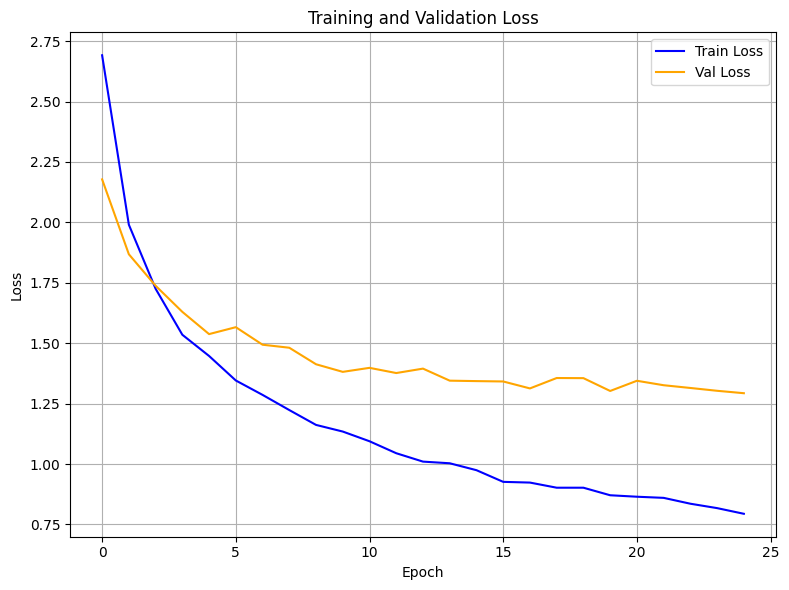

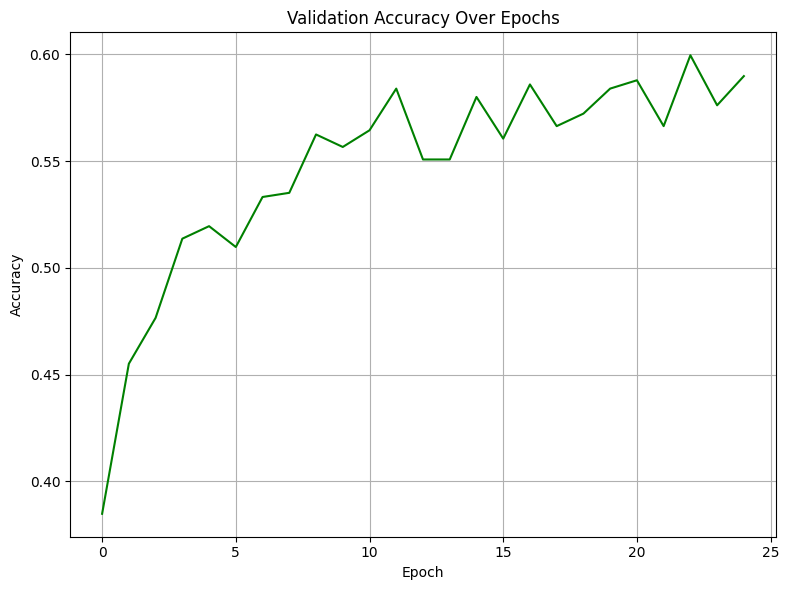

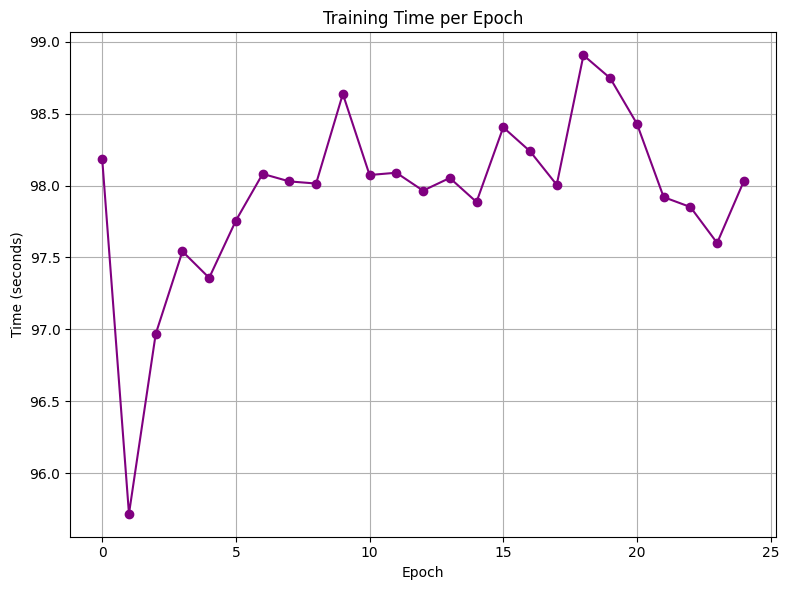


Test Accuracy: 62.23%

Precision, Recall, F1-Score Table:

                        precision  recall  f1-score
abstract_art                0.583   0.280     0.378
abstract_expressionism      0.700   0.560     0.622
amateur                     0.704   0.760     0.731
art_nouveau                 0.382   0.520     0.441
baroque                     0.700   0.875     0.778
chinese_landscape           0.522   0.857     0.649
constructivism              0.667   0.320     0.432
cubism                      0.739   0.680     0.708
expressionism               0.567   0.680     0.618
fauvism                     0.400   0.480     0.436
futurism                    0.889   0.640     0.744
high_renaissance            0.938   0.600     0.732
minimalism                  0.618   0.840     0.712
op_art                      0.654   0.680     0.667
pop_art                     0.533   0.640     0.582
post_impressionism          0.636   0.560     0.596
realism                     0.800   0.696     0.744
rena

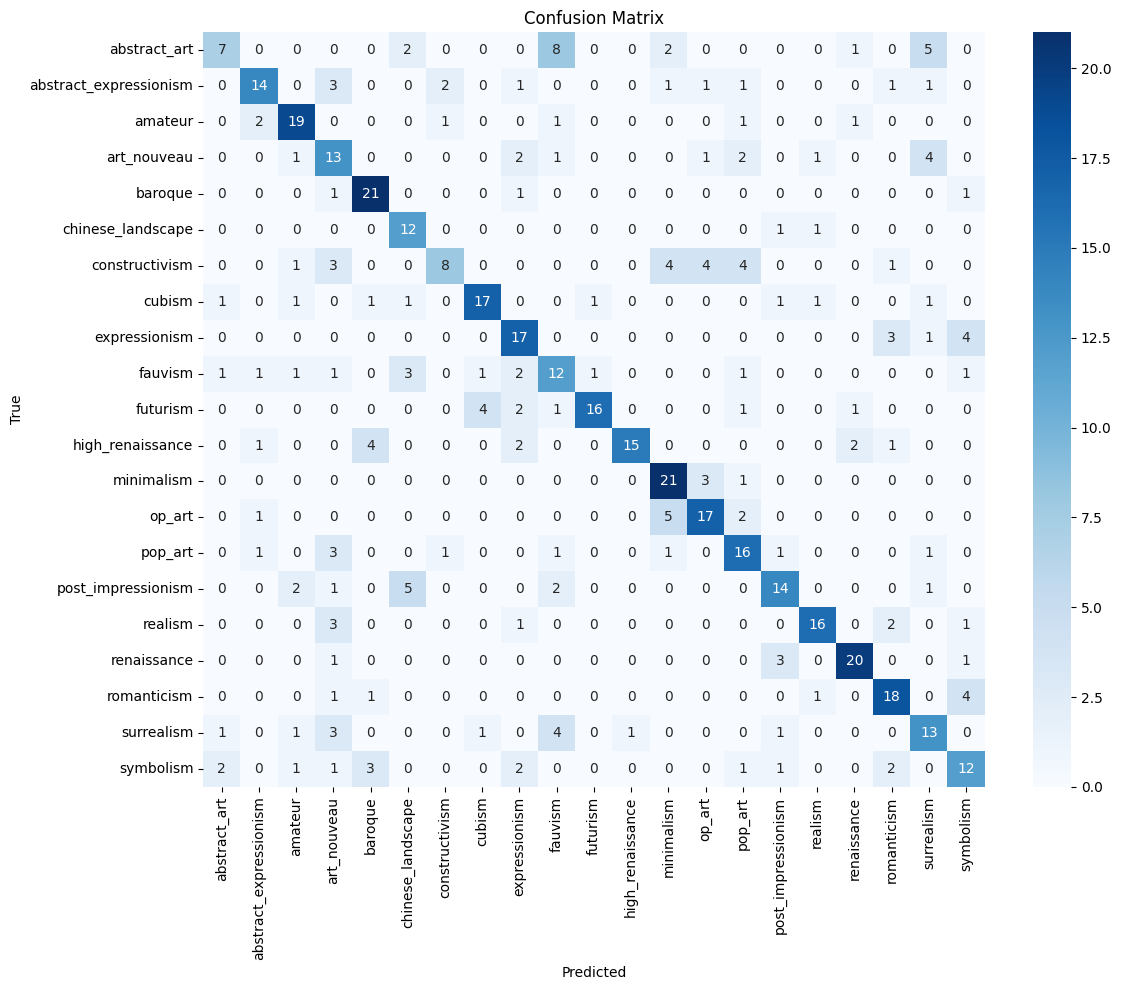

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import timm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
from tqdm import tqdm
import time

# ======== Device Configuration ========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ======== Data Transformations (224x224 for PIT) ========
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ======== Dataset and DataLoaders ========
dataset_path = "/content/MerakiNexus-V2/art_classification_model/dataset"
train_data = datasets.ImageFolder(root=f"{dataset_path}/train", transform=transform)
val_data = datasets.ImageFolder(root=f"{dataset_path}/val", transform=transform)
test_data = datasets.ImageFolder(root=f"{dataset_path}/test", transform=transform)

print(f"Train samples: {len(train_data)} | Val samples: {len(val_data)} | Test samples: {len(test_data)}")

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# ======== PIT Model Definition ========
class ArtworkClassificationPIT(nn.Module):
    def __init__(self, num_classes=11):
        super(ArtworkClassificationPIT, self).__init__()
        self.pit = timm.create_model("pit_b_224", pretrained=True)

        # Freeze all parameters
        for param in self.pit.parameters():
            param.requires_grad = False

        # Unfreeze classifier head and last stage (if desired)
        for param in self.pit.head.parameters():
            param.requires_grad = True

        # Replace classification head
        in_features = self.pit.head.in_features
        self.pit.head = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.pit(x)

model = ArtworkClassificationPIT(num_classes=len(train_data.classes)).to(device)

# ======== Loss Function and Optimizer ========
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-5)

# ======== Training Loop ========
num_epochs = 25
train_losses, val_losses, val_accuracies, epoch_times = [], [], [], []

print("\nStarting Training...\n")
for epoch in range(num_epochs):
    start = time.time()
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training") as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            tepoch.set_postfix(loss=loss.item())

    train_losses.append(running_loss / len(train_loader))

    # ======== Validation ========
    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            preds = outputs.argmax(dim=1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct_val / total_val)
    epoch_time = time.time() - start
    epoch_times.append(epoch_time)

    print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_accuracies[-1]*100:.2f}% | Time: {epoch_time:.2f}s")

print(f"\nTotal Training Time: {sum(epoch_times):.2f}s ({sum(epoch_times)/60:.2f} minutes)")

# ======== Plotting ========
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Train Loss", color='blue')
plt.plot(val_losses, label="Val Loss", color='orange')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(val_accuracies, label="Val Accuracy", color='green')
plt.title("Validation Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(epoch_times, marker='o', color='purple')
plt.title("Training Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.tight_layout()
plt.show()

# ======== Final Evaluation ========
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {test_acc * 100:.2f}%")

report = classification_report(all_labels, all_preds, target_names=train_data.classes, output_dict=True)
df_report = pd.DataFrame(report).transpose()

print("\nPrecision, Recall, F1-Score Table:\n")
print(df_report[['precision', 'recall', 'f1-score']].round(3))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_data.classes,
            yticklabels=train_data.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [5]:
scripted_model = torch.jit.script(model)  # Convert to TorchScript

# Save the TorchScript model to a file
torch.jit.save(scripted_model, "/content/artwork_classification_model_subject_2_PIT.pth");


✅ Test Accuracy: 56.95%

📊 Classification Report (per class):

                        precision  recall  f1-score
abstract_art                0.600   0.240     0.343
abstract_expressionism      0.600   0.360     0.450
amateur                     0.818   0.720     0.766
art_nouveau                 0.355   0.440     0.393
baroque                     0.636   0.875     0.737
chinese_landscape           0.600   0.857     0.706
constructivism              0.600   0.360     0.450
cubism                      0.727   0.640     0.681
expressionism               0.348   0.320     0.333
fauvism                     0.375   0.360     0.367
futurism                    0.652   0.600     0.625
high_renaissance            0.727   0.640     0.681
minimalism                  0.562   0.720     0.632
op_art                      0.593   0.640     0.615
pop_art                     0.548   0.680     0.607
post_impressionism          0.577   0.600     0.588
realism                     0.500   0.652     0.566


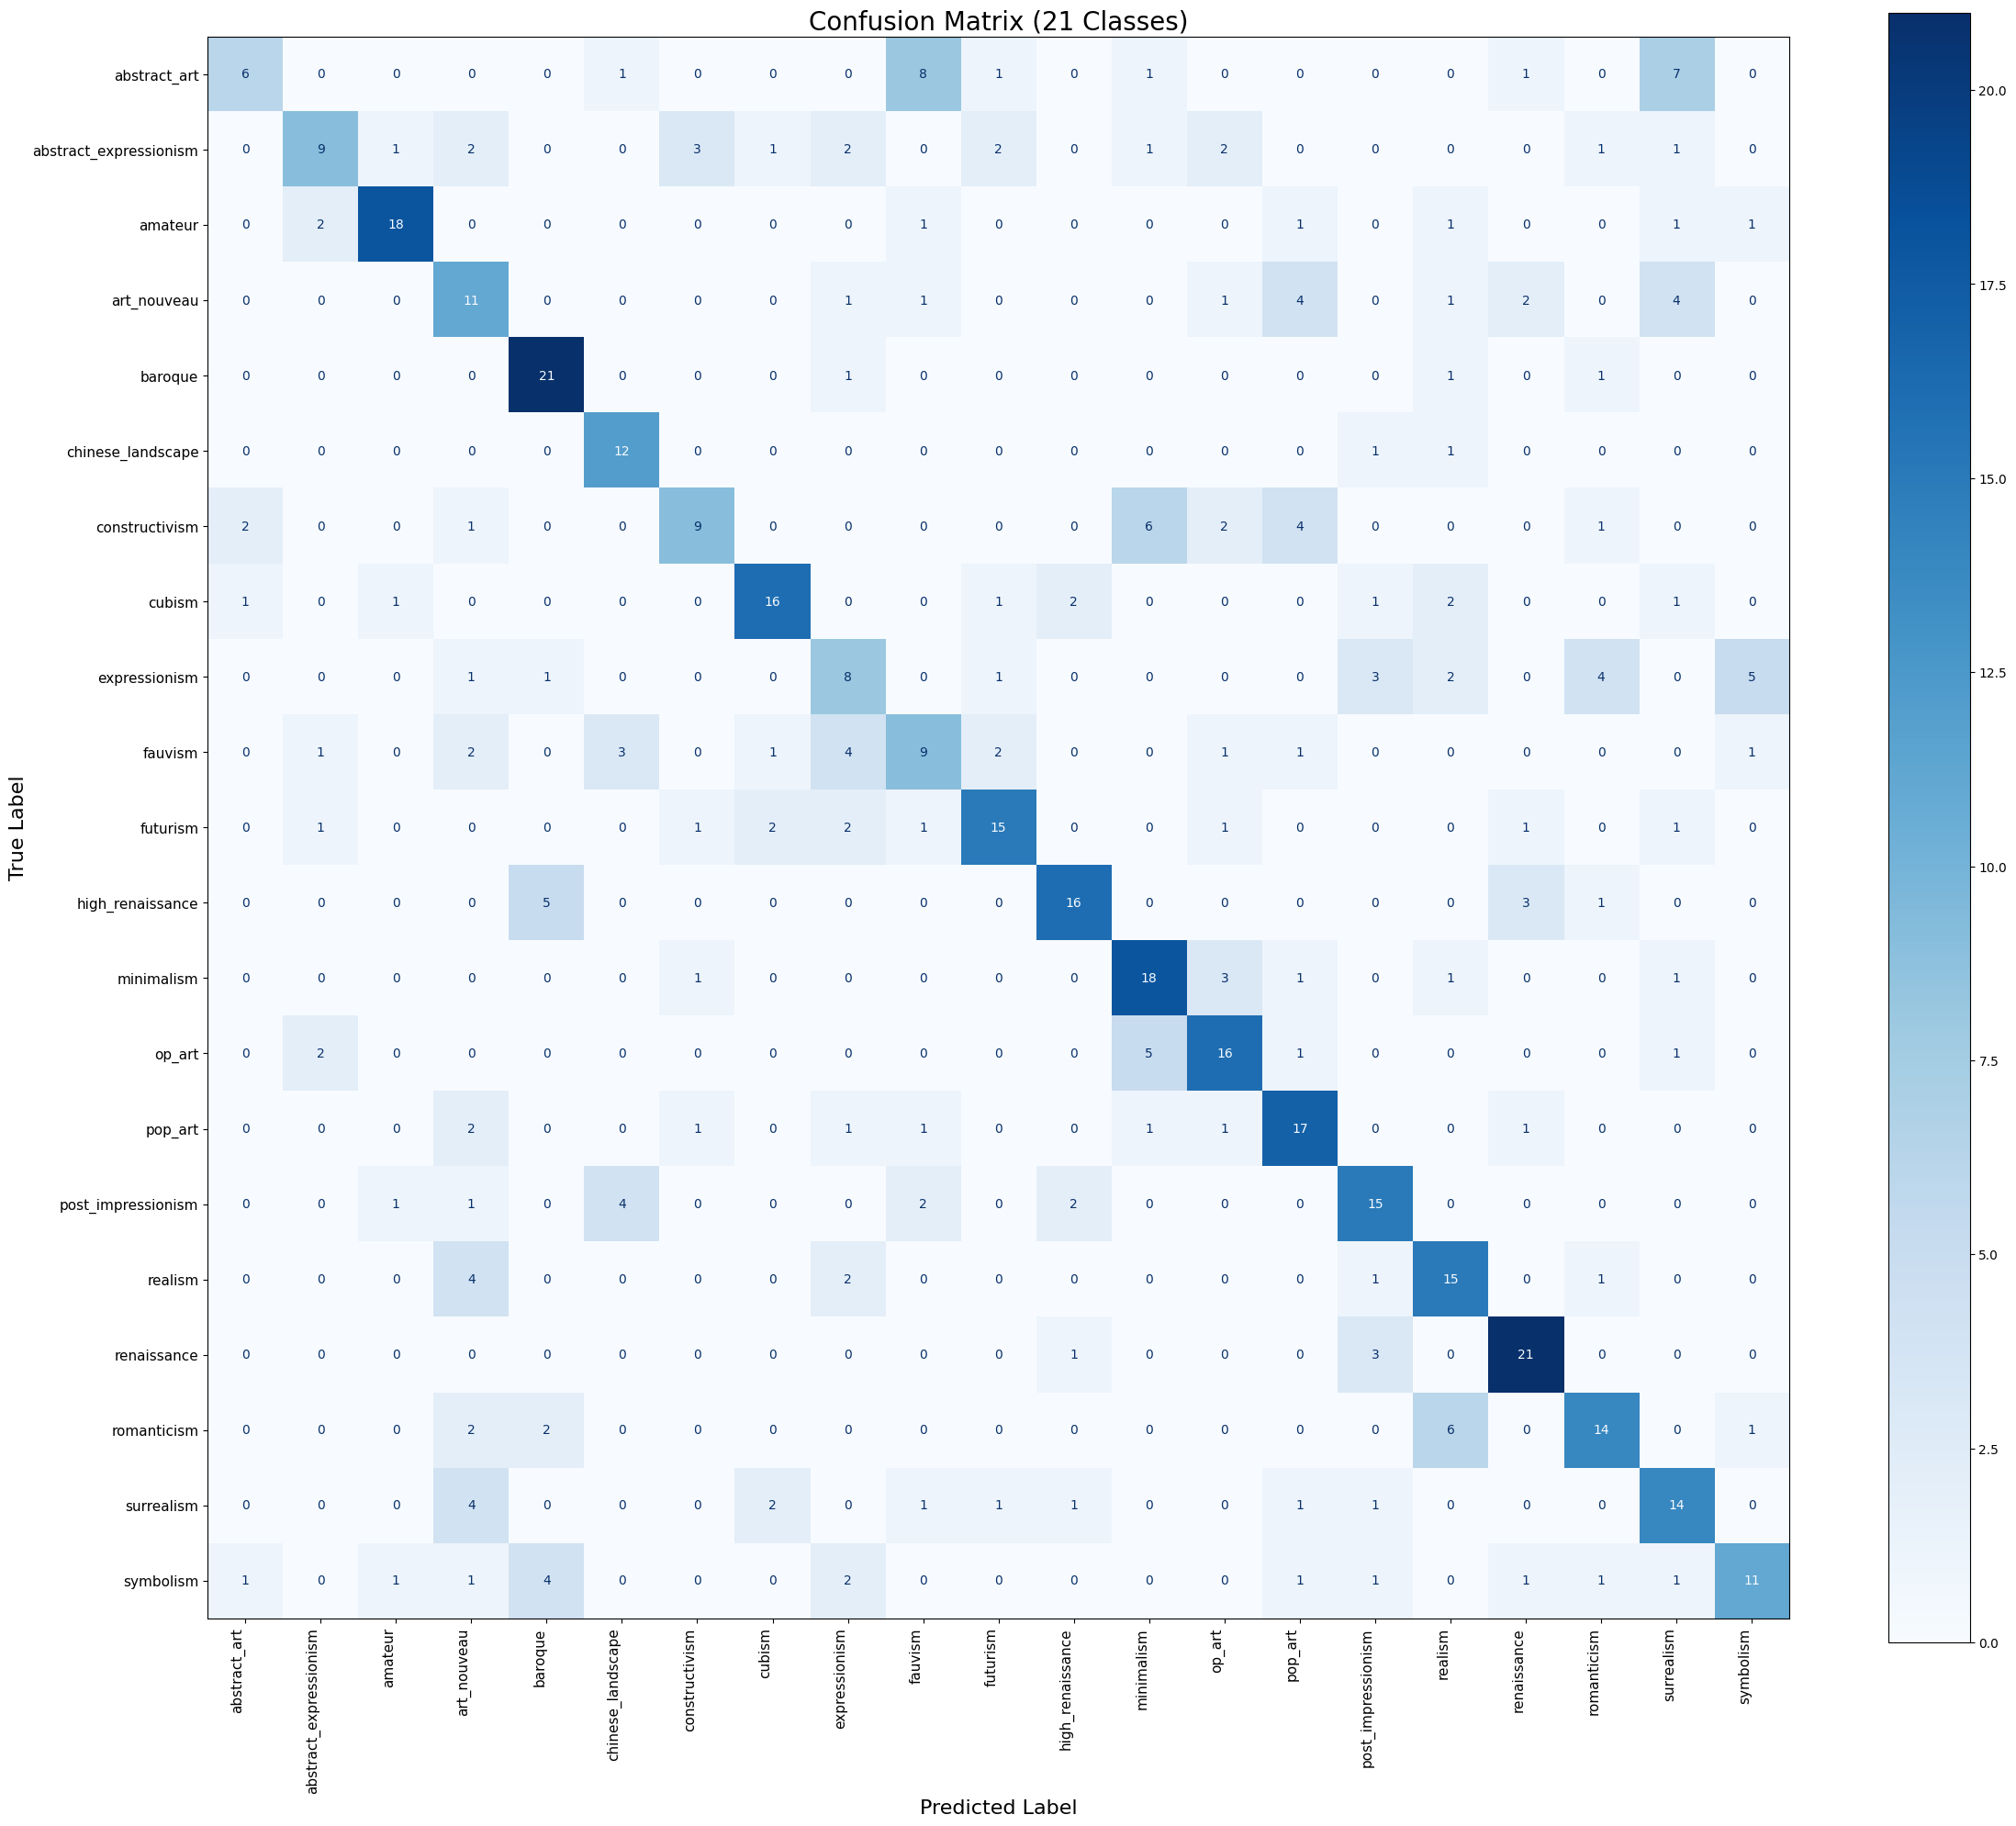

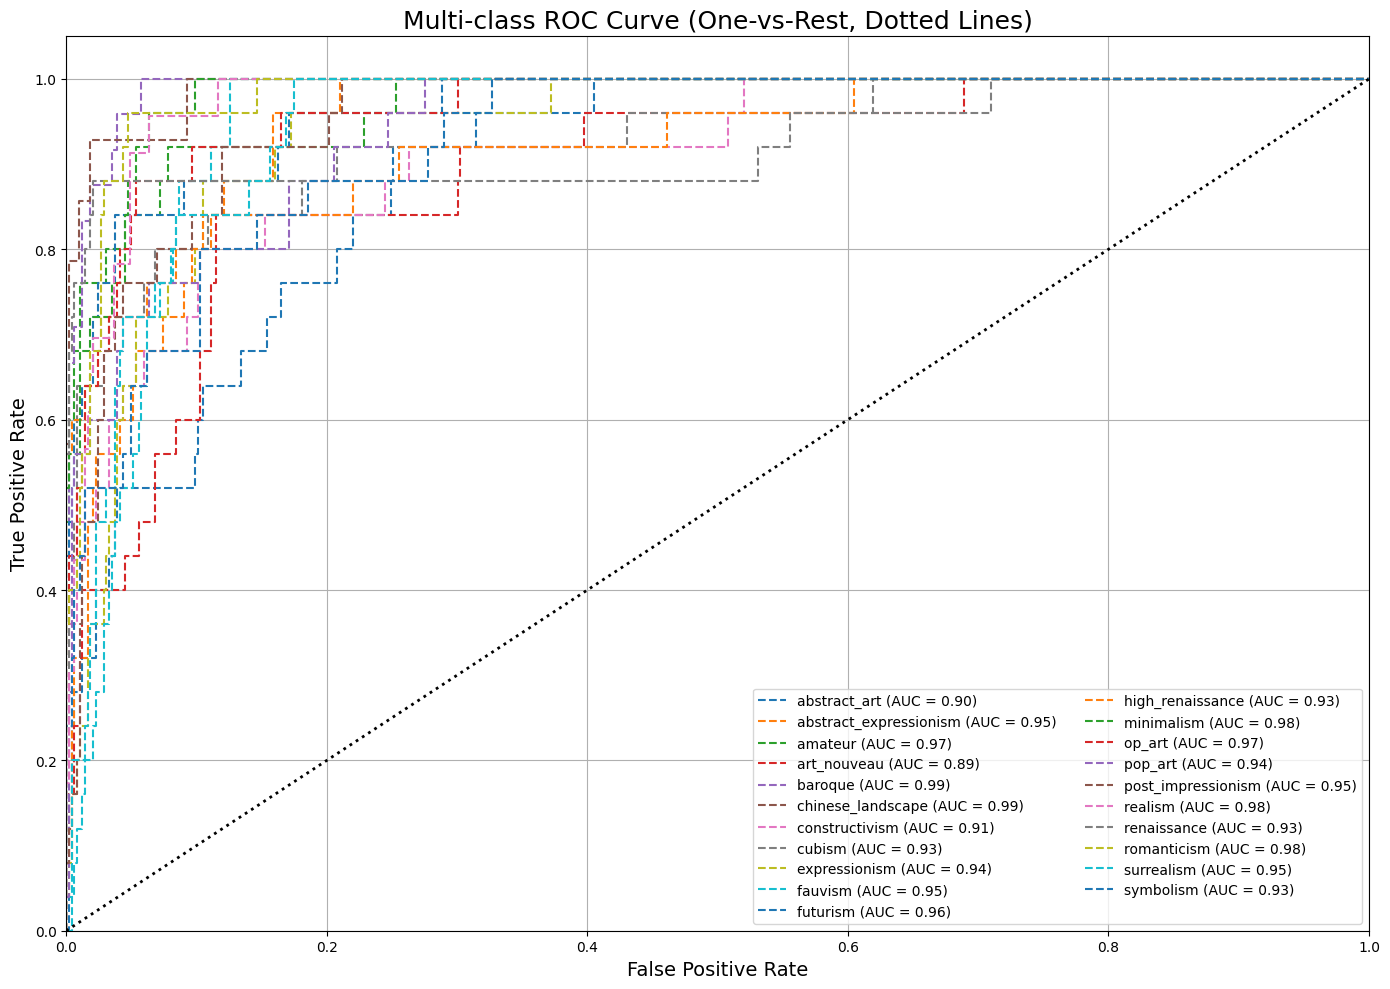

In [6]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import label_binarize

# ========== Define transforms ==========
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ========== Load the test dataset ==========
test_dataset = datasets.ImageFolder(
    '/content/MerakiNexus-V2/art_classification_model/dataset/test',
    transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
class_names = test_dataset.classes
num_classes = len(class_names)

# ========== Load TorchScript model ==========
scripted_model = torch.jit.load("/content/artwork_classification_model_subject_2_PIT.pth")
scripted_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scripted_model.to(device)

# ========== Evaluation on Test Set ==========
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = scripted_model(images)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# ========== Overall Test Accuracy ==========
test_accuracy = accuracy_score(all_labels, all_preds)
print(f"\n✅ Test Accuracy: {test_accuracy * 100:.2f}%")

# ========== Precision, Recall, F1-Score ==========
report = classification_report(
    all_labels,
    all_preds,
    target_names=class_names,
    digits=3,
    output_dict=True
)
df_metrics = pd.DataFrame(report).transpose()
print("\n📊 Classification Report (per class):\n")
print(df_metrics[['precision', 'recall', 'f1-score']].round(3))

# Optional: Save report as CSV
# df_metrics.to_csv("classification_metrics_test.csv")

# ========== Confusion Matrix ==========
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(24, 20))
disp.plot(
    cmap="Blues",
    values_format='d',
    ax=ax
)

plt.setp(ax.get_xticklabels(), rotation=90, ha='right', fontsize=11)
plt.setp(ax.get_yticklabels(), fontsize=11)
ax.set_title("Confusion Matrix (21 Classes)", fontsize=20)
ax.set_xlabel("Predicted Label", fontsize=16)
ax.set_ylabel("True Label", fontsize=16)
plt.tight_layout()
plt.show()

# ========== ROC Curve ==========
# Binarize labels
y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))
y_score = np.array(all_probs)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class as dotted lines
plt.figure(figsize=(14, 10))
for i in range(num_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        linestyle='--',
        lw=1.5,
        label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})"
    )

plt.plot([0, 1], [0, 1], 'k:', lw=2)  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("Multi-class ROC Curve (One-vs-Rest, Dotted Lines)", fontsize=18)
plt.legend(loc="lower right", fontsize=10, ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()
